# Learn Tensorflow via a linear regression model
In this excercise, you will learn tensorflow in steps. Please use python 3 and tensorflow >=1.4.0. 

In [3]:
# A bit of setup

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from implementations.a_tensorflow import regression_graph
from plot_graph import show_graph


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


## Tensorflow graph
In the first step, we test a tensorflow graph with all constants. Please read `a_tensorflow.regression_graph()`. It calculates the squared loss for the linear regression model. 

### <span style="color:red">Question 1 (4 points):</span>
Please run the code in the cell below, comment out the first line, and then run the cell multiple times. Why does the right-most graph get numbers on it nodes with your runs?

Answer: when you run the cell and not reset the default_graph, the result will generate on the former graph. So there are numbers of your iteration on the node.

In [6]:
#tf.reset_default_graph() 
loss = regression_graph() # the first function in a_tensorflow
show_graph(loss.graph)
session = tf.Session()
f = tf.get_default_graph().get_tensor_by_name('score:0')
p = tf.get_default_graph().get_tensor_by_name('inner_product:0')
d = tf.get_default_graph().get_tensor_by_name('difference:0')
l = tf.get_default_graph().get_tensor_by_name('squared_loss:0')
print('tf.inner_product:', session.run(p))
print('tf.add score:', session.run(f))
print('tf.difference:', session.run(d))
print('tf.loss:', session.run(l))

tf.inner_product: 1.2800001
tf.add score: 2.18
tf.difference: 1.98
tf.loss: 3.9204001


Note 1: use `tf.Session()` to run the graph and evaluate the value of a graph node. 
Note 2: retrieve a graph node by its name. 

### <span style="color:red">Question 2 (4 points):</span> 
Please uncomment the last two lines and evaluate the loss. 

In [4]:
tf.reset_default_graph()
loss = regression_graph(print_info=True)
session = tf.Session()

# retrieve the variable from the graph
f = tf.get_default_graph().get_tensor_by_name('score:0')
print("We retrieve f from the graph and show its value: ", session.run(f))

print('The loss is ')
session.run(loss)

Msg from the function: we can evaluate any value in the graph with tf.Session
Msg from the function: the value of f = w * x + b is 2.18
We retrieve f from the graph and show its value:  2.18
The loss is 


3.9204001

## Tensorflow graph with vectors

We can get a tensor's shape with its member function `get_shape()`. Note that this function is python function, not a tensorflow operation, so it runs when you build the graph. 

We can also use the tensorflow operation `tf.shape()` to get the shape of a tensor. Since it is an operation, it is part of the graph. You need to run the operation to get the actual value. 

### <span style="color:red">Question 3 (4 points):</span> 
Complete the code in the function `regression_graph_vectorized` so the following cell can run. 

In [5]:
from implementations.a_tensorflow import regression_graph_vectorized
tf.reset_default_graph() 
loss = regression_graph_vectorized(print_info=True)

print(tf.Session().run(loss))

By w.get_shape(), we get the shape of the tensor w: (2,)
With tf.shape(w), we get the shape of w as a one-element tensor: Tensor("Shape:0", shape=(1,), dtype=int32)
The shape of tf.matmul(x, w) is: (3, 1)
The shape of tf.squeeze(tf.matmul(x, w)) is: (3,)
35.343597


## Place holder in Tensorflow graph

A `placeholder` holds space for the data that will be fed into the graph in the future. It can has shape `None` in one or more dimensions. The size of that dimension will be decided by the data. 

### <span style="color:red">Question 4 (4 points):</span> 
Please implement the function `regression_graph_with_placeholder` and get the cell below run. 

In [6]:
from implementations.a_tensorflow import regression_graph_with_placeholder
tf.reset_default_graph() 

# build a graph with place holders
x = tf.placeholder(shape=[None, 2], dtype=tf.float32, name='feature')
y = tf.placeholder(shape=[None], dtype=tf.float32, name='label')

print('The place holder x is:', x) # take a look of the place holder

loss = regression_graph_with_placeholder(x=x, y=y)

# need to feed in actual values to x and y to evaluate the variable loss

# numpy values
np.random.seed(seed=2019)
npx = np.random.random_sample([10, 2])
npy = np.squeeze(npx.dot([[0.3], [0.6]])) + 1.0 + 0.05 * np.random.random_sample([10])

# this line cannot run because you need to feed in values for place holders. Can you fix it?
#tf.Session().run(loss) 

#tf.Session().run(loss, feed_dict={x: npx, y: npy})


# feed in a different set of data
npx = np.random.random_sample([10, 2])
npy = np.squeeze(npx.dot([[0.7], [0.9]])) + 1.0 + 0.05 * np.random.random_sample([10])

# it get a different loss value
tf.Session().run(loss, feed_dict={x: npx, y: npy})

The place holder x is: Tensor("feature:0", shape=(?, 2), dtype=float32)


8.833251

## Tensorflow graph with variables

We need to use `tf.Variable` to declare variables that we can optimize later. We often use `Variable`s for model parameters, which are mutable. We seldomly use `Variable`s for data. 

### <span style="color:red">Question 5 (4 points):</span> 
Please implement the function `regression_graph_with_variable` and get the cell below run. 

In [8]:
from implementations.a_tensorflow import regression_graph_with_variable
tf.reset_default_graph() 

w = tf.Variable(np.full(shape=[2], fill_value=1.6, dtype=np.float32), name='weight')
b = tf.Variable(tf.constant(0.9), name='bias')

loss = regression_graph_with_variable(w=w, b=b)

session = tf.Session()

init = tf.global_variables_initializer()
session.run(init)

session.run(loss) # you cannot directly run loss because you need to initialize variables first


35.343597

## Gradient calculation

Tensorflow can calculate gradient with respect to a `Variable` (but not a `constant` or a `placeholder`). Let's use an optimizer to optimize a gradient.


### <span style="color:red">Question 6 (4 points):</span> 
Please read the documentation of `compute_gradients` and `apply_gradients`. 
Can you update w and b ten times and make the loss smaller?

In [9]:

# initialize an optimizer
opt = tf.train.GradientDescentOptimizer(learning_rate=0.01)
grads_vars = opt.compute_gradients(loss, var_list=[w, b])
update = opt.apply_gradients(grads_vars)


print('The current loss is: ', session.run(loss))
print('The current variable gradients and values are')
print(session.run(grads_vars))

for iter in range(100):  # can you run multiple steps to minimize the loss?
    session.run(update)

print('The current loss is: ', session.run(loss))
print('The current variable gradients and values are')
print(session.run(grads_vars))


The current loss is:  35.343597
The current variable gradients and values are
[(array([ 9.504, 19.008], dtype=float32), array([1.6, 1.6], dtype=float32)), (35.64, 0.9)]
The current loss is:  0.067444816
The current variable gradients and values are
[(array([ 0.0680116 , -0.05762145], dtype=float32), array([1.1247977, 0.8942685], dtype=float32)), (0.012987673, -0.5761677)]


## Compose the full version of linear regression

### <span style="color:red">Question 7 (4 points):</span> 

Can you use all techniques you have learned above to compose a full version of linear regression? 

We use data with one feature only so we can plot the data easily. Assume the feature matrix is `npx` and the label is `npy`. 


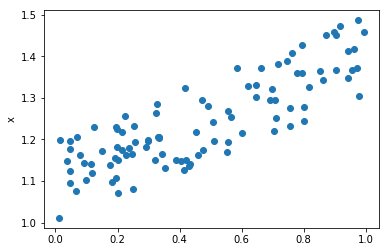

In [10]:
# plot the data before fitting the model. 
# numpy values
N = 100
npx = np.random.random_sample([N, 1])
npy = np.squeeze(npx.dot([[0.3]])) + 1.0 + 0.2 * np.random.random_sample([N])

plt.plot(npx, npy, 'o')
plt.ylabel('y')
plt.ylabel('x')
plt.show()


In [11]:
from implementations.a_tensorflow import regression_graph_full
tf.reset_default_graph() 

x = tf.placeholder(shape=[None, 1], dtype=tf.float32, name='feature')
y = tf.placeholder(shape=[None,], dtype=tf.float32, name='label')

w = tf.Variable(np.full(shape=[1], fill_value=1.6, dtype=np.float32), name='weight')
b = tf.Variable(tf.constant(0.9), name='bias')

loss = regression_graph_full(x=x, y=y, w=w, b=b) # you need to implement this function to contruct the graph

# get an optimizer
opt = tf.train.GradientDescentOptimizer(learning_rate=0.001)

# calculate the gradient with compute_gradients
grads_vars = opt.compute_gradients(loss, var_list=[w, b])

# get an update operation with apply_gradients
update = opt.apply_gradients(grads_vars)

# get a session
session = tf.Session()

# initialize your variables, namely w and b
init = tf.global_variables_initializer()
session.run(init)

# get feeding dictionary
N = 100
npx = np.random.random_sample([N, 1])
npy = np.squeeze(npx.dot([[0.3]])) + 1.0 + 0.2 * np.random.random_sample([N])
print(npy.shape)
feed_dict ={x: npx, y: npy}

print('The current loss is: ', session.run(loss, feed_dict=feed_dict))
print('The current variable gradients and values are')
print(session.run(grads_vars, feed_dict=feed_dict)) # something is missing here?

for iter in range(1000):  # Run 1000 steps to minimize the loss
    
    # perform gradient steps by running the update operation 
    session.run(update, feed_dict=feed_dict)
    
    if iter % 100 == 1:
        print('Loss values become: ', session.run(loss, feed_dict=feed_dict))


# obtain the trained model        
npw = session.run(w)
npb = session.run(b)

(100,)
The current loss is:  37.787987
The current variable gradients and values are
[(array([72.54155], dtype=float32), array([1.6], dtype=float32)), (97.20121, 0.9)]
Loss values become:  17.829512
Loss values become:  1.0954198
Loss values become:  0.39654472
Loss values become:  0.3382031
Loss values become:  0.33333284
Loss values become:  0.33292636
Loss values become:  0.3328924
Loss values become:  0.33288962
Loss values become:  0.33288935
Loss values become:  0.3328892


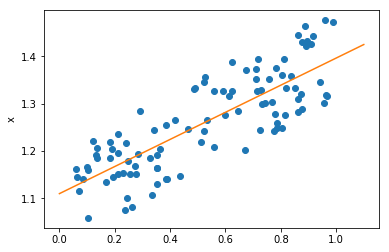

In [12]:
# Plot the result
npw = session.run(w)
x_line = np.arange(12) / 10.0
y_line = x_line * np.squeeze(npw) + npb

plt.plot(npx, npy, 'o')
plt.plot(x_line, y_line)
plt.ylabel('y')
plt.ylabel('x')
plt.show()
